In [1]:
! pip install -U scikit-learn

In [1]:
import illustris_python as il
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from sklearn import metrics
from sklearn.model_selection import cross_validate, KFold, cross_val_predict, GridSearchCV

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.neighbors import KNeighborsRegressor

In [3]:
! wget -nc --content-disposition --header="API-Key: e2697a415abd570c10a94b88d11b044a" "http://www.tng-project.org/api/TNG100-1/files/stellar_photometry.91.hdf5"

URL transformed to HTTPS due to an HSTS policy
--2023-09-29 06:45:40--  https://www.tng-project.org/api/TNG100-1/files/stellar_photometry.91.hdf5
Resolving www.tng-project.org (www.tng-project.org)... 130.183.17.94
Connecting to www.tng-project.org (www.tng-project.org)|130.183.17.94|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data-eu.tng-project.org/file/stellar_photometry/L75n1820TNG/91/?token=b8dd438058463d7c78a5 [following]
--2023-09-29 06:45:40--  https://data-eu.tng-project.org/file/stellar_photometry/L75n1820TNG/91/?token=b8dd438058463d7c78a5
Resolving data-eu.tng-project.org (data-eu.tng-project.org)... 130.183.17.94
Connecting to data-eu.tng-project.org (data-eu.tng-project.org)|130.183.17.94|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [4]:
import h5py

with h5py.File('Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_091.hdf5', 'r') as hf:
    print (list (hf.keys()))
    s_id = hf['subhaloIDs'][:]
    phot = hf['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc'][:]

['Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc', 'subhaloIDs']


In [5]:
s_id.shape

(4449889,)

In [6]:
basePath = '../sims.TNG/TNG100-1/output'

In [7]:
mtype = il.groupcat.loadSubhalos(basePath, 91, fields=['SubhaloMassType'])
gmetal = il.groupcat.loadSubhalos(basePath, 91, fields=['SubhaloGasMetallicity'])
sfr = il.groupcat.loadSubhalos(basePath, 91, fields=['SubhaloSFR'])

In [8]:
sfr.shape

(4449889,)

In [9]:
pdgmetal = pd.DataFrame(gmetal, columns=['Gas Metallicity'])
pdsfr = pd.DataFrame(sfr, columns=['Stellar Formation Rate'])
pds_id = pd.DataFrame(s_id, columns =['Subhalo ID'])

In [10]:
gmass = mtype[:,0]
dmmass = mtype[:,1]
stmass = mtype[:,4]
bhmass = mtype[:,5]

In [11]:
pdgmass = np.log10((pd.DataFrame(gmass, columns=['Gas Mass']))*(10**10))
pddmmass = np.log10((pd.DataFrame(dmmass, columns=['Dark Matter Mass']))*(10**10))
pdstmass = np.log10((pd.DataFrame(stmass, columns=['Stellar Mass']))*(10**10))
pdbhmass = np.log10((pd.DataFrame(bhmass, columns=['Black Hole Mass']))*(10**10))

/opt/conda/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


In [12]:
pdgmass

,Gas Mass
0,13.560769
1,10.616130
2,9.833848
3,8.702189
4,10.616083
...,...
4449884,-inf
4449885,-inf
4449886,-inf
4449887,-inf


In [13]:
pdgmetal.replace(to_replace = 0, value = 10**-8, inplace=True)
pdsfr.replace(to_replace = 0, value = 10**-8, inplace=True)
pdgmass.replace(to_replace = -np.inf, value = 8, inplace=True)
pddmmass.replace(to_replace = -np.inf, value = 8, inplace=True)
pdstmass.replace(to_replace = -np.inf, value = 8, inplace=True)
pdbhmass.replace(to_replace = -np.inf, value = 8, inplace=True) 

pdgmetal.fillna(0,inplace=True)
pdsfr.fillna(0,inplace=True)
pdgmass.fillna(0,inplace=True)
pddmmass.fillna(0,inplace=True)
pdstmass.fillna(0,inplace=True)
pdbhmass.fillna(0,inplace=True)

In [14]:
df = pd.DataFrame(pdgmetal)
df['Stellar Formation Rate'] = pdsfr
df['Gas Mass'] = pdgmass
df['Stellar Mass'] = pdstmass
df['Black Hole Mass'] = pdbhmass
df['Dark Matter Mass'] = pddmmass
df['Subhalo ID'] = pds_id

In [15]:
df['Stellar Mass'] = df['Stellar Mass'][(df['Stellar Mass'] > 9)]
df['Dark Matter Mass'] = df['Dark Matter Mass'][(df['Dark Matter Mass'] > 9)]

In [16]:
df

,Gas Metallicity,Stellar Formation Rate,Gas Mass,Stellar Mass,Black Hole Mass,Dark Matter Mass,Subhalo ID
0,3.920325e-03,1.191226e+01,13.560769,12.189700,9.722685,14.337951,0
1,1.873566e-02,3.078836e+01,10.616130,11.680132,9.218714,12.360020,1
2,1.576501e-02,1.733503e+00,9.833848,11.401999,8.900289,12.290783,2
3,1.192400e-02,1.000000e-08,8.702189,11.214507,8.796812,12.363271,3
4,1.047468e-02,1.204401e+00,10.616083,11.025040,8.616725,12.339453,4
...,...,...,...,...,...,...,...
4449884,1.000000e-08,1.000000e-08,8.000000,NaN,8.000000,NaN,4449884
4449885,1.000000e-08,1.000000e-08,8.000000,NaN,8.000000,NaN,4449885
4449886,1.000000e-08,1.000000e-08,8.000000,NaN,8.000000,NaN,4449886
4449887,1.000000e-08,1.000000e-08,8.000000,NaN,8.000000,NaN,4449887


In [17]:
ddf = df.dropna()

In [18]:
ddf

,Gas Metallicity,Stellar Formation Rate,Gas Mass,Stellar Mass,Black Hole Mass,Dark Matter Mass,Subhalo ID
0,3.920325e-03,1.191226e+01,13.560769,12.189700,9.722685,14.337951,0
1,1.873566e-02,3.078836e+01,10.616130,11.680132,9.218714,12.360020,1
2,1.576501e-02,1.733503e+00,9.833848,11.401999,8.900289,12.290783,2
3,1.192400e-02,1.000000e-08,8.702189,11.214507,8.796812,12.363271,3
4,1.047468e-02,1.204401e+00,10.616083,11.025040,8.616725,12.339453,4
...,...,...,...,...,...,...,...
746965,1.000000e-08,1.000000e-08,8.000000,9.070190,8.000000,10.350875,746965
757298,1.000000e-08,1.000000e-08,8.000000,9.032024,8.000000,10.256576,757298
772129,2.301487e-02,1.872653e-02,8.282676,9.004390,8.000000,9.991588,772129
778887,1.000000e-08,1.000000e-08,8.000000,9.002027,8.000000,10.200853,778887


In [19]:
reshaped_phot = phot.reshape(4449889, 8 * 12)

colu = []
for f in range(8):
    for sub in range(12):
        colu.append(f'feature_{f}_sub_{sub}')
ph = pd.DataFrame(data=reshaped_phot, columns=colu)
ph['Subhalo ID'] = pds_id

matching_elements = []
for i in ph['Subhalo ID']:
    if i in ddf['Subhalo ID'].values:
        matching_elements.append(i)
    else :
        matching_elements.append(np.nan)     
matching_series = pd.Series(matching_elements)

In [20]:
matching_elements = np.zeros(len(ph['Subhalo ID']))
for idx, i in enumerate(ph['Subhalo ID']):
    if i in ddf['Subhalo ID'].values:
        matching_elements[idx] = i
    else :
        matching_elements[idx] = np.nan
                             
matching_series = pd.Series(matching_elements)

In [21]:
matching_series

0          0.0
1          1.0
2          2.0
3          3.0
4          4.0
          ... 
4449884    NaN
4449885    NaN
4449886    NaN
4449887    NaN
4449888    NaN
Length: 4449889, dtype: float64

In [22]:
#pph = ph.dropna()
#for f in range(8):
    #for sub in range(1, 12):
        #pph = pph.drop(columns=(f'feature_{f}_sub_{sub}'))

In [23]:
pph = ph.dropna()
for f in range(8):
    for sub in range(1, 12):
        pph = pph.drop(columns=(f'feature_{f}_sub_{sub}'))   
    if f > 4: 
        pph = pph.drop(columns=(f'feature_{f}_sub_0'))

In [24]:
pph['u-g'] = pph['feature_0_sub_0'] - pph['feature_1_sub_0']
pph['g-r'] = pph['feature_1_sub_0'] - pph['feature_2_sub_0']
pph['r-i'] = pph['feature_2_sub_0'] - pph['feature_3_sub_0']
pph['i-z'] = pph['feature_3_sub_0'] - pph['feature_4_sub_0']

In [25]:
pph['Matched IDs'] = matching_series
ppph = pph.dropna()

In [26]:
ppph['Matched IDs'] = ppph['Matched IDs'].astype(int)

/tmp/ipykernel_126/1382364284.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppph['Matched IDs'] = ppph['Matched IDs'].astype(int)


In [27]:
ppph

,feature_0_sub_0,feature_1_sub_0,feature_2_sub_0,feature_3_sub_0,feature_4_sub_0,Subhalo ID,u-g,g-r,r-i,i-z,Matched IDs
0,-20.593021,-22.422171,-23.232534,-23.637362,-23.995768,0,1.829149,0.810364,0.404827,0.358406,0
1,-21.890554,-23.154871,-23.729202,-24.056564,-24.364653,1,1.264317,0.574331,0.327362,0.308088,1
2,-20.367485,-21.993053,-22.700130,-23.067825,-23.393227,2,1.625568,0.707077,0.367695,0.325401,2
3,-19.557058,-21.306505,-22.087584,-22.480154,-22.819138,3,1.749447,0.781078,0.392570,0.338984,3
4,-19.595139,-21.141136,-21.839962,-22.205723,-22.526999,4,1.545998,0.698826,0.365761,0.321276,4
...,...,...,...,...,...,...,...,...,...,...,...
746965,-15.285927,-16.838699,-17.534170,-17.881359,-18.150757,746965,1.552773,0.695471,0.347189,0.269398,746965
757298,-15.135825,-16.690088,-17.383066,-17.731005,-18.002151,757298,1.554263,0.692978,0.347939,0.271147,757298
772129,-15.190722,-16.700409,-17.358328,-17.701681,-17.982338,772129,1.509686,0.657919,0.343353,0.280657,772129
778887,-15.257939,-16.776371,-17.452665,-17.786982,-18.041084,778887,1.518432,0.676294,0.334316,0.254103,778887


In [28]:
co = ddf.merge(pph, how = 'inner')

In [29]:
co

,Gas Metallicity,Stellar Formation Rate,Gas Mass,Stellar Mass,Black Hole Mass,Dark Matter Mass,Subhalo ID,feature_0_sub_0,feature_1_sub_0,feature_2_sub_0,feature_3_sub_0,feature_4_sub_0,u-g,g-r,r-i,i-z,Matched IDs
0,3.920325e-03,1.191226e+01,13.560769,12.189700,9.722685,14.337951,0,-20.593021,-22.422171,-23.232534,-23.637362,-23.995768,1.829149,0.810364,0.404827,0.358406,0.0
1,1.873566e-02,3.078836e+01,10.616130,11.680132,9.218714,12.360020,1,-21.890554,-23.154871,-23.729202,-24.056564,-24.364653,1.264317,0.574331,0.327362,0.308088,1.0
2,1.576501e-02,1.733503e+00,9.833848,11.401999,8.900289,12.290783,2,-20.367485,-21.993053,-22.700130,-23.067825,-23.393227,1.625568,0.707077,0.367695,0.325401,2.0
3,1.192400e-02,1.000000e-08,8.702189,11.214507,8.796812,12.363271,3,-19.557058,-21.306505,-22.087584,-22.480154,-22.819138,1.749447,0.781078,0.392570,0.338984,3.0
4,1.047468e-02,1.204401e+00,10.616083,11.025040,8.616725,12.339453,4,-19.595139,-21.141136,-21.839962,-22.205723,-22.526999,1.545998,0.698826,0.365761,0.321276,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17250,1.000000e-08,1.000000e-08,8.000000,9.070190,8.000000,10.350875,746965,-15.285927,-16.838699,-17.534170,-17.881359,-18.150757,1.552773,0.695471,0.347189,0.269398,746965.0
17251,1.000000e-08,1.000000e-08,8.000000,9.032024,8.000000,10.256576,757298,-15.135825,-16.690088,-17.383066,-17.731005,-18.002151,1.554263,0.692978,0.347939,0.271147,757298.0
17252,2.301487e-02,1.872653e-02,8.282676,9.004390,8.000000,9.991588,772129,-15.190722,-16.700409,-17.358328,-17.701681,-17.982338,1.509686,0.657919,0.343353,0.280657,772129.0
17253,1.000000e-08,1.000000e-08,8.000000,9.002027,8.000000,10.200853,778887,-15.257939,-16.776371,-17.452665,-17.786982,-18.041084,1.518432,0.676294,0.334316,0.254103,778887.0


In [30]:
#Features = co[['feature_0_sub_0','feature_1_sub_0','feature_2_sub_0','feature_3_sub_0','feature_4_sub_0','feature_5_sub_0','feature_6_sub_0','feature_7_sub_0']]
#Target = co['Dark Matter Mass']
#X_train, X_test, Y_train, Y_test = train_test_split(Features, Target, test_size=0.1)

In [31]:
Features = co[['feature_0_sub_0', 'feature_1_sub_0', 'feature_2_sub_0', 'feature_3_sub_0', 'feature_4_sub_0']]
Target = co['Dark Matter Mass']
X_train, X_test, Y_train, Y_test = train_test_split(Features, Target, test_size=0.1)

In [32]:
X_train.shape

(15529, 5)

In [33]:
Target.shape

(17255,)

prediction :  [11.05125237 10.75335217 11.75204086 ... 11.25331593 11.71100426
 11.56132317]
R2 Score :  0.45028516808349195
The mean square value :  0.21807123324429017
The Score :  {'fit_time': array([0.1705606 , 0.16661596, 0.16378188, 0.16754818, 0.17022133,
       0.16948843, 0.16566563]), 'score_time': array([0.00274587, 0.00230837, 0.00223351, 0.00276136, 0.00254321,
       0.0027957 , 0.00229096]), 'test_score': array([0.53399621, 0.48054529, 0.472874  , 0.50078111, 0.51458708,
       0.48667928, 0.49083051]), 'train_score': array([1., 1., 1., 1., 1., 1., 1.])}
Test Score :  0.49718478514025444
Train Score :  1.0
Cross Vaidate prediction :  [14.02041245 14.05238152 13.36330128 ... 10.67436504 10.29518414
  9.85269642]


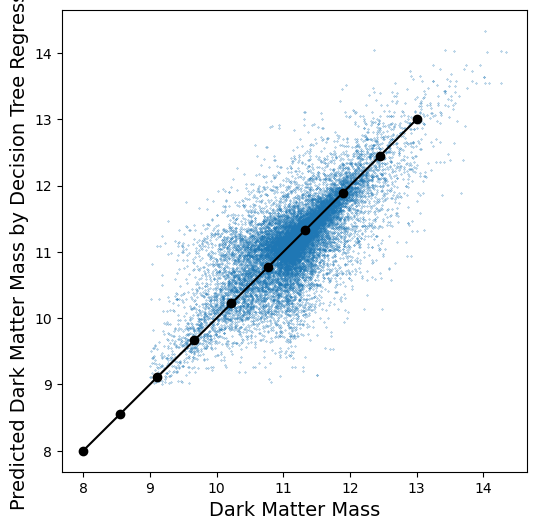

In [34]:
Regressor = DecisionTreeRegressor()
Regressor.fit(X_train, Y_train)
Y_pred = Regressor.predict(X_test)
print ("prediction : ", Y_pred)

R = r2_score(Y_test, Y_pred)
print ("R2 Score : ", R)

Mse = mean_squared_error(Y_test, Y_pred)
print ("The mean square value : ", Mse)

Scores = cross_validate(Regressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10), return_train_score=True)
S = np.mean(Scores['test_score'])
print ("The Score : ", Scores)
print ("Test Score : ", S)
print ("Train Score : ", np.mean(Scores['train_score']))

Cvpred = cross_val_predict(Regressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10))
print ("Cross Vaidate prediction : ", Cvpred)

m = np.linspace(8, 13, 10)
n = m

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(Target,Cvpred, '.', markersize=0.5)
ax.plot(m, n, color='black', linestyle='-', marker='o')
ax.set_xlabel('Dark Matter Mass', fontsize=14)
ax.set_ylabel('Predicted Dark Matter Mass by Decision Tree Regressor',fontsize=14)
plt.show()

prediction :  [11.05125237 10.75335217 11.75204086 ... 11.39722252 11.60515118
 11.56132317]
R2 Score :  0.45323305924379764
The mean square value :  0.21690180825614386
The Score :  {'fit_time': array([0.16778564, 0.16554713, 0.16424775, 0.16385555, 0.17096734,
       0.16764259, 0.16281962]), 'score_time': array([0.00237536, 0.00216031, 0.00255084, 0.00227642, 0.00261092,
       0.00229979, 0.00218081]), 'test_score': array([0.53994198, 0.49006302, 0.46319702, 0.50076314, 0.51445139,
       0.47828226, 0.48325895]), 'train_score': array([1., 1., 1., 1., 1., 1., 1.])}
Test Score :  0.4957082510541337
Train Score :  1.0
Cross Vaidate prediction :  [14.02041245 14.05238152 13.21386719 ... 10.59387112 10.29518414
  9.58230686]
Pearson Correlation Coefficient: 0.7456528434147667
P-value: 0.0


Text(0, 0.5, 'Predicted Dark Matter Mass by Decision Tree Regressor')

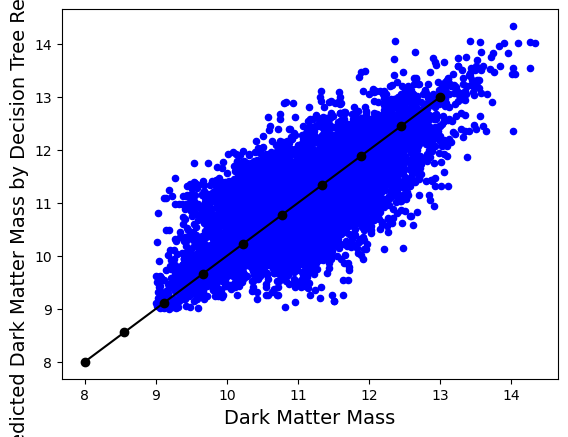

In [35]:
Regressor = DecisionTreeRegressor()
Regressor.fit(X_train, Y_train)
Y_pred = Regressor.predict(X_test)
print ("prediction : ", Y_pred)

R = r2_score(Y_test, Y_pred)
print ("R2 Score : ", R)

Mse = mean_squared_error(Y_test, Y_pred)
print ("The mean square value : ", Mse)

Scores = cross_validate(Regressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10), return_train_score=True)
S = np.mean(Scores['test_score'])
print ("The Score : ", Scores)
print ("Test Score : ", S)
print ("Train Score : ", np.mean(Scores['train_score']))

Cvpred = cross_val_predict(Regressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10))
print ("Cross Vaidate prediction : ", Cvpred)

C_coeff, P_value = stats.pearsonr(Cvpred.reshape((17255,)), Target)
print("Pearson Correlation Coefficient:", C_coeff)
print("P-value:", P_value)

m = np.linspace(8, 13, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,Cvpred, s = 20, c = 'blue')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass by Decision Tree Regressor',fontsize=14)

prediction :  [11.543288 11.381108 11.273961 ... 11.262249 11.501334 11.614006]
R2 Score :  0.6454307195238413
The mean square value :  0.14065722
The Score :  {'fit_time': array([0.02584791, 0.02531481, 0.02527523, 0.02509308, 0.0252347 ,
       0.02501893, 0.02495098]), 'score_time': array([0.01035595, 0.01017475, 0.01083183, 0.00990081, 0.01029134,
       0.01000524, 0.01054478]), 'test_score': array([0.69419952, 0.67172016, 0.66837711, 0.67252307, 0.66423577,
       0.66415364, 0.6677438 ]), 'train_score': array([0.83706269, 0.838846  , 0.83710767, 0.83793949, 0.83591505,
       0.8361694 , 0.83852512])}
Test Score :  0.6718504375418509
Train Score :  0.8373664881643456
Cross Vaidate prediction :  [13.709363 13.80539  12.886151 ... 10.603256 10.370715  9.742323]
Pearson Correlation Coefficient: 0.8230826735143671
P-value: 0.0


Text(0, 0.5, 'Predicted Dark Matter Mass by KNN Regressor')

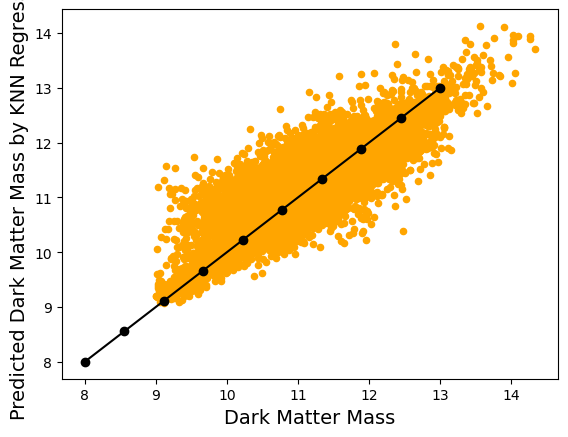

In [36]:
KnnRegressor = KNeighborsRegressor(n_neighbors=3)
KnnRegressor.fit(X_train, Y_train)
KY_pred = KnnRegressor.predict(X_test)
print ("prediction : ", KY_pred)

KR = r2_score(Y_test, KY_pred)
print ("R2 Score : ", KR)

KMse = mean_squared_error(Y_test, KY_pred)
print ("The mean square value : ", KMse)

KScores = cross_validate(KnnRegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10), return_train_score=True)
KS = np.mean(KScores['test_score'])
print ("The Score : ", KScores)
print ("Test Score : ", KS)
print ("Train Score : ", np.mean(KScores['train_score']))

KCvpred = cross_val_predict(KnnRegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10))
print ("Cross Vaidate prediction : ", KCvpred)

KC_coeff, KP_value = stats.pearsonr(KCvpred.reshape((17255,)), Target)
print("Pearson Correlation Coefficient:", KC_coeff)
print("P-value:", KP_value)

m = np.linspace(8, 13, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,KCvpred, s = 20, c = 'orange')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass by KNN Regressor',fontsize=14)

prediction :  [11.7545595 11.062002  11.165961  ... 10.89363   11.315635  11.898603 ]
R2 Score :  0.6957267568849776
The mean square value :  0.120704845
The Score :  {'fit_time': array([0.00375843, 0.00482488, 0.00478697, 0.0046947 , 0.00469947,
       0.00469136, 0.00473666]), 'score_time': array([0.04517245, 0.02329278, 0.00239277, 0.00239897, 0.00247931,
       0.00235438, 0.00247478]), 'test_score': array([0.72050406, 0.70079564, 0.7028042 , 0.69858694, 0.69819817,
       0.6962241 , 0.69778402]), 'train_score': array([0.69929296, 0.70274531, 0.70241521, 0.70311735, 0.70317845,
       0.70345616, 0.70323898])}
Test Score :  0.7021281620154126
Train Score :  0.7024920600092924
Cross Vaidate prediction :  [12.523466  13.121964  12.536046  ... 10.1739855 10.41555    9.894964 ]
Pearson Correlation Coefficient: 0.8380563603298693
P-value: 0.0


Text(0, 0.5, 'Predicted Dark Matter Mass by Linear Regressor')

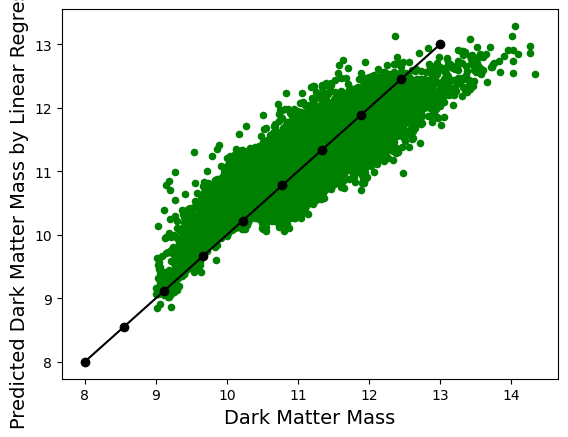

In [37]:
LRegressor = LinearRegression()
LRegressor.fit(X_train, Y_train)
LY_pred = LRegressor.predict(X_test)
print ("prediction : ", LY_pred)

LR = r2_score(Y_test, LY_pred)
print ("R2 Score : ", LR)

LMse = mean_squared_error(Y_test, LY_pred)
print ("The mean square value : ", LMse)

LScores = cross_validate(LRegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10), return_train_score=True)
LS = np.mean(LScores['test_score'])
print ("The Score : ", LScores)
print ("Test Score : ", LS)
print ("Train Score : ", np.mean(LScores['train_score']))

LCvpred = cross_val_predict(LRegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10))
print ("Cross Vaidate prediction : ", LCvpred)

LC_coeff, LP_value = stats.pearsonr(LCvpred.reshape((17255,)), Target)
print("Pearson Correlation Coefficient:", LC_coeff)
print("P-value:", LP_value)

m = np.linspace(8, 13, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,LCvpred, s = 20, c = 'green')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass by Linear Regressor',fontsize=14)

prediction :  [11.51240776 11.26451071 11.43068462 ... 11.16310202 11.40404261
 11.56706696]
R2 Score :  0.6837446364587942
The mean square value :  0.12545813418770332
The Score :  {'fit_time': array([11.13566542, 11.10706615, 11.0491221 , 11.07412028, 11.11851621,
       11.22669291, 11.28098202]), 'score_time': array([0.08888936, 0.08810997, 0.0893867 , 0.10212922, 0.09064913,
       0.10698771, 0.09008527]), 'test_score': array([0.73581752, 0.71388765, 0.70787395, 0.71091516, 0.71362874,
       0.69811501, 0.70681032]), 'train_score': array([0.95908884, 0.96016008, 0.95949251, 0.95957085, 0.95970059,
       0.9603729 , 0.96027478])}
Test Score :  0.7124354774533377
Train Score :  0.9598086487442986
Cross Vaidate prediction :  [13.49656562 13.80566351 13.04918302 ... 10.54065886 10.34244711
  9.6993447 ]
Pearson Correlation Coefficient: 0.8446728795791464
P-value: 0.0


Text(0, 0.5, 'Predicted Dark Matter Mass by Random Forest Regressor')

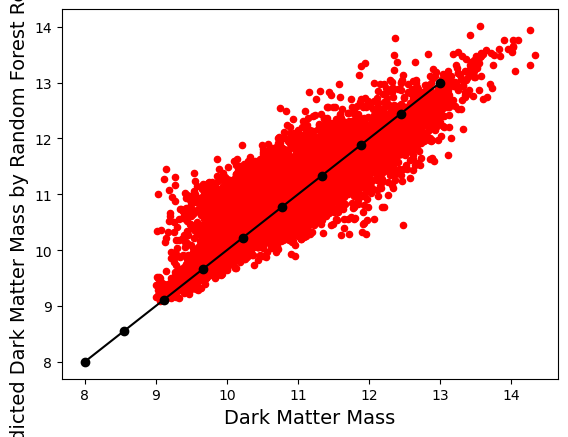

In [38]:
FORegressor = RandomForestRegressor()
FORegressor.fit(X_train, Y_train)
FOY_pred = FORegressor.predict(X_test)
print ("prediction : ", FOY_pred)

FOR = r2_score(Y_test, FOY_pred)
print ("R2 Score : ", FOR)

FOMse = mean_squared_error(Y_test, FOY_pred)
print ("The mean square value : ", FOMse)

FOScores = cross_validate(FORegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10), return_train_score=True)
FOS = np.mean(FOScores['test_score'])
print ("The Score : ", FOScores)
print ("Test Score : ", FOS)
print ("Train Score : ", np.mean(FOScores['train_score']))

FOCvpred = cross_val_predict(FORegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10))
print ("Cross Vaidate prediction : ", FOCvpred)

FC_coeff, FP_value = stats.pearsonr(FOCvpred.reshape((17255,)), Target)
print("Pearson Correlation Coefficient:", FC_coeff)
print("P-value:", FP_value)

m = np.linspace(8, 13, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,FOCvpred, s = 20, c = 'red')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass by Random Forest Regressor',fontsize=14)

prediction :  [11.52156927 11.25040581 11.55570192 ... 11.14020679 11.42458075
 11.5768598 ]
R2 Score :  0.6693260500301372
The mean square value :  0.13117797062212244
The Score :  {'fit_time': array([2.80856538, 2.80051637, 2.79455996, 2.82546687, 2.7930963 ,
       2.79596329, 2.81470108]), 'score_time': array([0.10230827, 0.10162425, 0.10269666, 0.10178137, 0.09970832,
       0.10297489, 0.09998465]), 'test_score': array([0.72015696, 0.6983448 , 0.69546742, 0.69919994, 0.70051214,
       0.68851256, 0.69102934]), 'train_score': array([1., 1., 1., 1., 1., 1., 1.])}
Test Score :  0.6990318801381472
Train Score :  1.0
Cross Vaidate prediction :  [13.81751628 13.74216409 12.93161714 ... 10.60545986 10.32093485
  9.78054946]
Pearson Correlation Coefficient: 0.8376928416505759
P-value: 0.0


Text(0, 0.5, 'Predicted Dark Matter Mass by Extreme Random Forest Regressor')

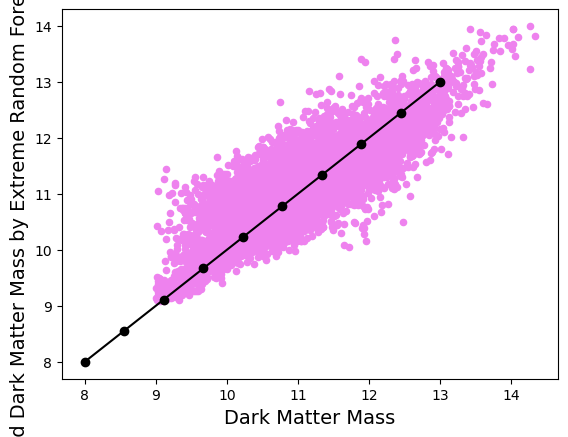

In [39]:
ETRegressor = ExtraTreesRegressor(n_estimators=100, random_state=33)
ETRegressor.fit(X_train, Y_train)
ETY_pred = ETRegressor.predict(X_test)
print ("prediction : ", ETY_pred)

ETR = r2_score(Y_test, ETY_pred)
print ("R2 Score : ", ETR)

ETMse = mean_squared_error(Y_test, ETY_pred)
print ("The mean square value : ", ETMse)

ETScores = cross_validate(ETRegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10), return_train_score=True)
ETS = np.mean(ETScores['test_score'])
print ("The Score : ", ETScores)
print ("Test Score : ", ETS)
print ("Train Score : ", np.mean(ETScores['train_score']))

ETCvpred = cross_val_predict(ETRegressor,Features,Target, cv = KFold(n_splits=7, shuffle=True, random_state=10))
print ("Cross Vaidate prediction : ", ETCvpred)

ETC_coeff, ETP_value = stats.pearsonr(ETCvpred.reshape((17255,)), Target)
print("Pearson Correlation Coefficient:", ETC_coeff)
print("P-value:", ETP_value)

m = np.linspace(8, 13, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,ETCvpred, s = 20, c = 'violet')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass by Extreme Random Forest Regressor',fontsize=14)

 Model Comparisons for Case 2 


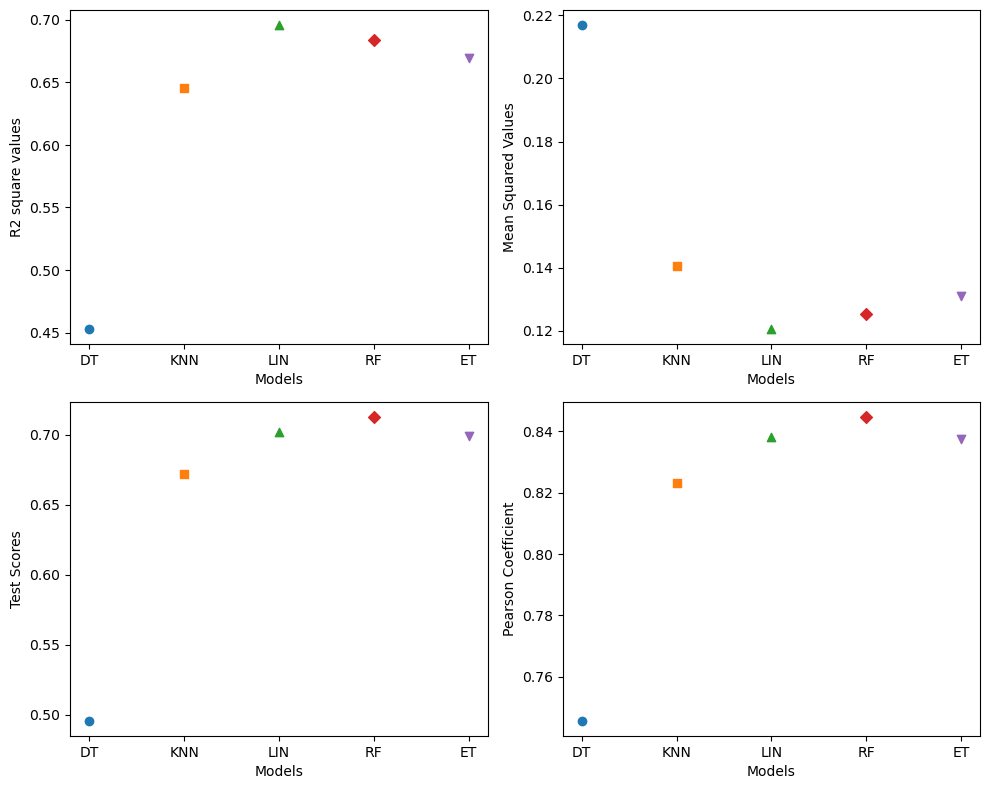

In [40]:
# COMPARISON GRAPH (CASE 2)

print ("\033[1m Model Comparisons for Case 2 \033[0m")

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
#R square
plt.plot(figsize=(4, 4))
g = [R, KR, LR, FOR, ETR]
h = ['DT', 'KNN', 'LIN', 'RF', 'ET']
shapes = ['o', 's', '^', 'D', 'v']
for i in range(len(g)):
    plt.scatter(h[i], g[i], marker=shapes[i])
plt.xlabel('Models')
plt.ylabel('R2 square values')

#Mean Squared Error

plt.subplot(2, 2, 2)
plt.plot(figsize=(4, 4))
gg = [Mse, KMse, LMse, FOMse, ETMse]
hh = ['DT', 'KNN', 'LIN', 'RF', 'ET']
shapes = ['o', 's', '^', 'D', 'v']
for i in range(len(gg)):
    plt.scatter(hh[i], gg[i], marker=shapes[i])
plt.xlabel('Models')
plt.ylabel('Mean Squared Values')

#Test Scores

plt.subplot(2, 2, 3)
plt.plot(figsize=(4, 4))
G = [S, KS, LS, FOS, ETS]
H = ['DT', 'KNN', 'LIN', 'RF', 'ET']
shapes = ['o', 's', '^', 'D', 'v']
for j in range(len(G)):
    plt.scatter(H[j], G[j], marker=shapes[j])
plt.xlabel('Models')
plt.ylabel('Test Scores')

#Pearson Correlation

plt.subplot(2, 2, 4)
plt.plot(figsize=(4, 4))
GC = [C_coeff, KC_coeff, LC_coeff, FC_coeff, ETC_coeff]
HC = ['DT', 'KNN', 'LIN', 'RF', 'ET']
shapes = ['o', 's', '^', 'D', 'v']
for j in range(len(GC)):
    plt.scatter(HC[j], GC[j], marker=shapes[j])
plt.xlabel('Models')
plt.ylabel('Pearson Coefficient')

plt.tight_layout()
plt.savefig('FOdiff comparisons.png')
plt.show()

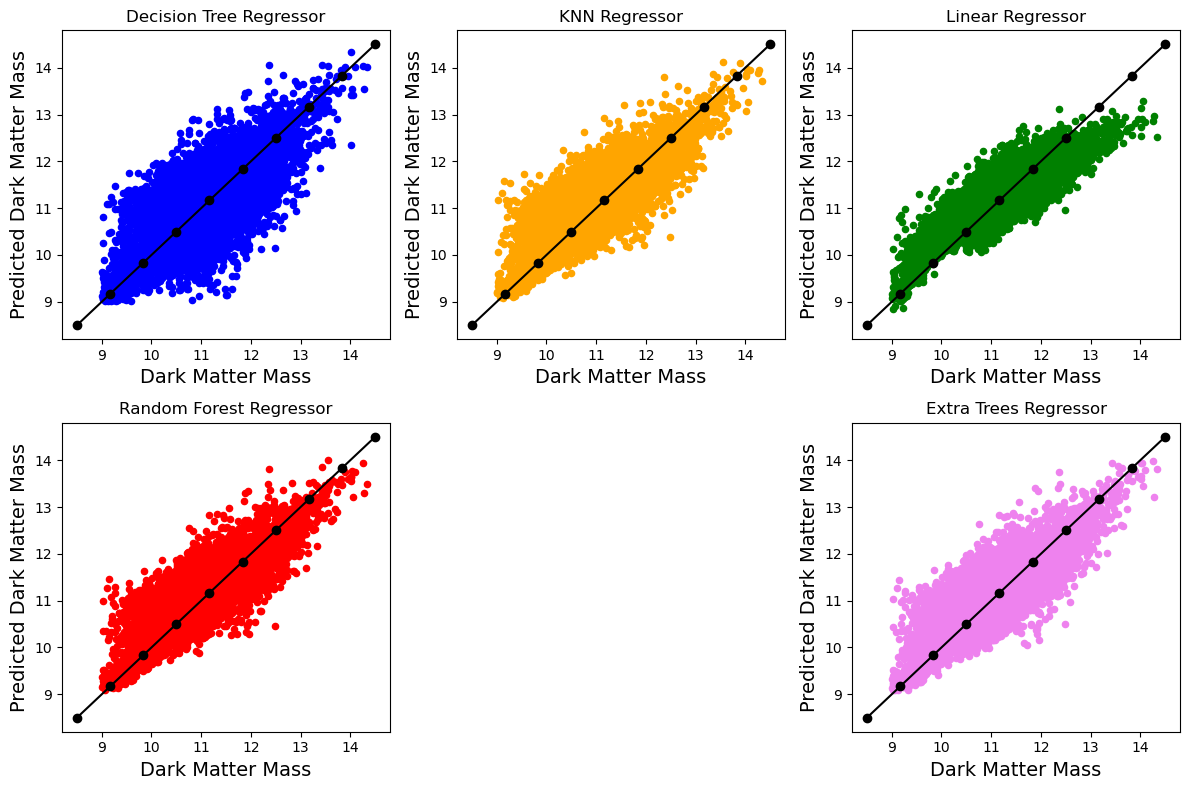

In [41]:
plt.figure(figsize=(12, 8))

# DT
plt.subplot(2, 3, 1)
m = np.linspace(8.5, 14.5, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,Cvpred, s = 20, c = 'blue')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass',fontsize=14)
plt.title('Decision Tree Regressor')

# KNN
plt.subplot(2, 3, 2)
m = np.linspace(8.5, 14.5, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,KCvpred, s = 20, c = 'orange')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass',fontsize=14)
plt.title('KNN Regressor')

# LIN
plt.subplot(2, 3, 3)
m = np.linspace(8.5, 14.5, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,LCvpred, s = 20, c = 'green')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass',fontsize=14)
plt.title('Linear Regressor')

# RF
plt.subplot(2, 3, 4)
m = np.linspace(8.5, 14.5, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,FOCvpred, s = 20, c = 'red')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass',fontsize=14)
plt.title('Random Forest Regressor')


# ETR
plt.subplot(2, 3, 6)
m = np.linspace(8.5, 14.5, 10)
n = m
plt.plot(m, n, color='black', linestyle='-', marker='o')

plt.scatter(Target,ETCvpred, s = 20, c = 'violet')
plt.xlabel('Dark Matter Mass', fontsize=14)
plt.ylabel('Predicted Dark Matter Mass',fontsize=14)
plt.title('Extra Trees Regressor')

plt.tight_layout()
plt.savefig('FOdiff models.png')
plt.show()